## Click [**HERE**](https://tmensinger.com/blog.html) to get back to my blog.

In [1]:
%%html
<link href="https://fonts.googleapis.com/css2?family=Bellefair&family=Josefin+Sans:wght@348&family=Josefin+Slab&display=swap" rel="stylesheet">
<style>
.text_cell_render {
font-family: 'Josefin Sans', sans-serif, 'Bellefair';
font-size: 12pt;
}
</style>

# Overlapping densities (Ridge plots)

## TL:DR

If you work yourself until the end of this notebook you will find a (more or less) general function which produces pretty plots like this 

![](https://rawcdn.githack.com/timmens/timmens.github.io/e5a7d83c685c0e5ba761440f4a01198ac29ab2a0/files/ridge_plot.png)

## Introduction
For an ongoing project I needed to compare the distribution of a variable given a related (categorical) feature. That is I have a data set $\{(y_i, x_i) : i=1,\dots,n\}$ and $x_i$ has at least one dimension which is categorical. A standard way to visualize a lot of this information is via overlapping density plots, usually called ridgeline plots.

Here I will show you how you can use [seaborn](https://seaborn.pydata.org/) to get a quick first plot and that you might have to use [matplotlib](https://matplotlib.org/) if you want more customization.

In [2]:
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

I am using a data set with one outcome *qoi* and several named features. For each observation I compute the distance of the features to the average feature. Given this distance I group the observations into intervals. I am interested in if and how the distribution of the outcome differs for these groups. Importantly, from the original data set I create a data frame which contains the outcome of interest *qoi* and another (categorical) column *group*. To compare the invidual groups to the complete sample at the end I add the complete sample as a group.

In [3]:
df = pd.read_pickle("../data/ridgeplot_data.pkl")

outcome = df[["qoi"]].copy()

features = df.drop("qoi", axis=1)
features = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns,
)

distances = features.apply(lambda row: np.linalg.norm(row), axis=1).to_frame("distance")
distances["group"] = pd.cut(
    x=distances["distance"],
    bins=[0, 6, 8, 9, 10, 11, 12, 14, int(distances["distance"].max()) + 1],
)

data_tmp = pd.concat((outcome, distances[["group"]]), axis=1)
outcome["group"] = pd._libs.interval.Interval(0, 16)
data = pd.concat((data_tmp, outcome), axis=0)

## matplotlib implementation

At the beginning I tried to create the plot I imagined using seaborn with the help of this nice [template](https://seaborn.pydata.org/examples/kde_ridgeplot); however, I quickly realized that I did not really understand how to customize every tiny bit so I switched to matplotlib. If you are very familiar with the seaborn API or satisfied with a simple plot I recommend looking at the template as it involves less code and only the seaborn package. But now to the matplot implementation.

For this I oriented myself on the nice [tutorial](https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/); but, I adjusted the code heavily and made a sensible function out of it. Please feel free to suggest improvements!

Most importantly the function expects a data frame structured as explained in the introduction and a list of group names corresponding to the group column in the data frame. The order of the list later determines the order of the subplots. To make the function independent of the seaborn package I hardcoded a visually appealing color palette which can otherwise be accessed through ``sns.cubehelix_palette(10, rot=-0.3, light=0.7)`` and further I used [sklearn's](https://scikit-learn.org/stable/) ``KernelDensity`` to compute the density plots instead of the popular ``seaborn.kdeplot``.

To use the function out-of-the-box I tried to make as many graphical parameters usable and even some statistical. Moreover I added the two arguments ``first_group_complete`` and ``publication_ready``.


#####  ``first_group_complete``

This (boolean) argument is used when the first element of the argument ``groups`` denotes the **complete** sample. For example, ``groups = ['humans', 'children', 'adults']``. In this case some adjustments to the plot are made automatically.

##### ``publication_ready``

Colorful plots can look beautiful on the internet but for publications it is often better to use black and white figures. With this (boolean) parameter all colors are deactivated and if necessary differences between areas are visualized via patterns. 

In [6]:
def ridge_plot(
    df,
    groups,
    value_col="qoi",
    xlim=(-0.2, 1),
    figsize=(16, 10),
    col_palette=None,
    bw=0.015,
    kernel="epanechnikov",
    first_group_is_complete=True,
    ticker_value=0.25,
    hspace=-0.25,
    publication_ready=False,
):
    """Create overlapping densities plot.

    Args:
        df (pd.DataFrame): Data frame containing a value column (name passed as
            argument), and a group column (must be called "group"), that classifies each
            row to a single group. Note that the group must be categorical.
        groups (list): List of unique group names contained in df["group"]. The order of
            this list determines the order of the subplots.
        value_col (str): Name of value column.
        xlim (tuple): x-axis limits.
        figsize (tuple): Figure size.
        col_palette (list): Color palette. If None, defaults to
            itertools.cycle(seaborn.cubehelix_palette(10, rot=-.3, light=.7)).
        bw (float): Bandwidth for the density estimation kernel.
        first_group_is_complete (bool): If after getting the unique ordered groups the
            first group represents the complete sample.
        ticker_value (float): Float passed to matplotlib.ticker.MultipleLocator.
        hspace (float): Float passed to grid_spec.GridSpec().update.
        publication_ready (bool): If True the plot is generated in black and white.

    Returns:
        fig (matplotlib.figure.Figure): The ridge plot figure.

    """
    if col_palette is None:
        col_palette = itertools.cycle(
            [
                [0.5542728401165395, 0.7695111327768686, 0.7424293850239434],
                [0.48074132506944434, 0.7076550245279908, 0.7043336083684792],
                [0.415619966862078, 0.6415373688838383, 0.6661585119301697],
                [0.36187657462305156, 0.5762587041377625, 0.6281032312096417],
                [0.3115422795524257, 0.5039229399475449, 0.5829515566874145],
                [0.2671682478057056, 0.42979148038743764, 0.5311760948785271],
                [0.22950098402102104, 0.35967733834707893, 0.47521262123396524],
                [0.19163415868814648, 0.2853905664320337, 0.406523236809716],
                [0.15636032025364718, 0.21730746943680534, 0.3331383745960979],
                [0.11670781642374867, 0.14752211647373256, 0.24517491899857707],
            ]
        )
    else:
        col_palette = itertools.cycle(col_palette)

    n_groups = len(groups)
    n_obs = len(df) / 2 if first_group_is_complete else len(df)

    gs = grid_spec.GridSpec(n_groups, 1)
    fig = plt.figure(figsize=figsize)

    kde = KernelDensity(kernel=kernel, bandwidth=bw)

    for i, g in enumerate(groups):
        color = "tan" if i == 0 and first_group_is_complete else next(col_palette)
        options = (
            ("black", "white", "black", "black", 1, None),
            ("white", color, color, color, 1.5, "bold")
        )
        edgecol, facecol, fontcol, hlinecol, hlinelw, fontweight = options[0] if publication_ready else options[1]

        # create plotting data
        data = df.query("group==@g")[value_col].to_numpy()
        freq = (len(data) / n_obs) * 100

        # train kernel density estimator and evaluate on grid
        kde.fit(data[:, None])
        x = np.linspace(xlim[0], xlim[1], 500)
        log_prob = kde.score_samples(x[:, None])
        density = np.exp(log_prob)

        # creating new axes object for each group
        ax = fig.add_subplot(gs[i : i + 1, 0:])  # noqa: E203

        # actual plotting
        kwargs = {"hatch": "//"} if i == 0 and first_group_is_complete else {}
        ax.fill_between(
            x, density, 0, edgecolor=edgecol, facecolor=facecol, lw=1.5, **kwargs
        )
        ax.axhline(y=0, lw=hlinelw, clip_on=False, color=hlinecol)

        # set xlim
        ax.set_xlim(*xlim)

        # make background transparent
        rect = ax.patch
        rect.set_alpha(0)

        # remove axis ticks, labels and borders
        ax.set_yticklabels([])
        if i != n_groups - 1:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_value))

        spines = ["top", "right", "left", "bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)

        # add group text, percentages (this need changing depending on the application)
        fontweight = "bold" if i == 0 else fontweight
        ax.text(
            -0.1, 1.5, g, fontweight=fontweight, fontsize=14, ha="right", color=fontcol
        )
        ax.text(
            1,
            1.5,
            f"{freq:.1f}%",
            fontweight=fontweight,
            fontsize=14,
            ha="right",
            color=fontcol,
        )

    gs.update(hspace=hspace)
    return fig

In [7]:
def _grouper(series):
    """Extract unique groups from series and order.

    For my application I need the elements to be sorted using classical sort, but
    on top I need the complete interval (0, 16] to be the first element.

    Args:
        series (pd.Series): The series from which the unique elements are selected.

    Returns:
        unique (list): The unique elements ordered.

    """
    unique = np.sort(series.unique()).tolist()
    unique[0], unique[1] = unique[1], unique[0]
    return unique

In [8]:
groups = _grouper(data["group"])

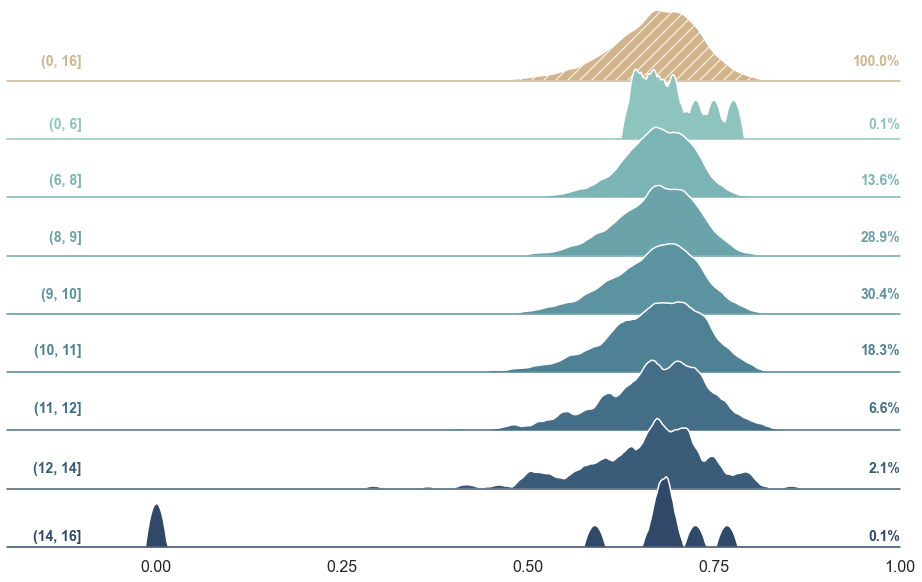

In [9]:
fig = ridge_plot(data, groups, publication_ready=False, first_group_is_complete=True)

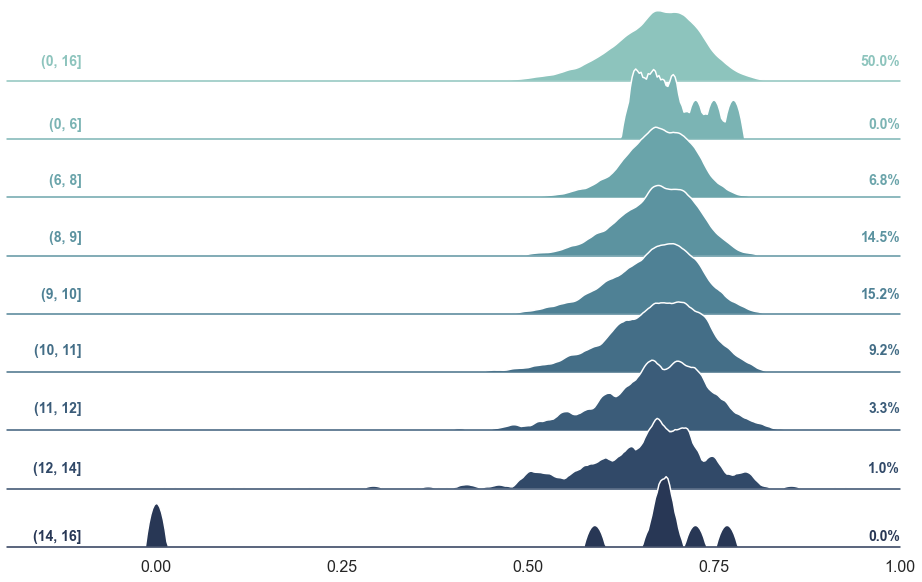

In [10]:
fig = ridge_plot(data, groups, publication_ready=False, first_group_is_complete=False)

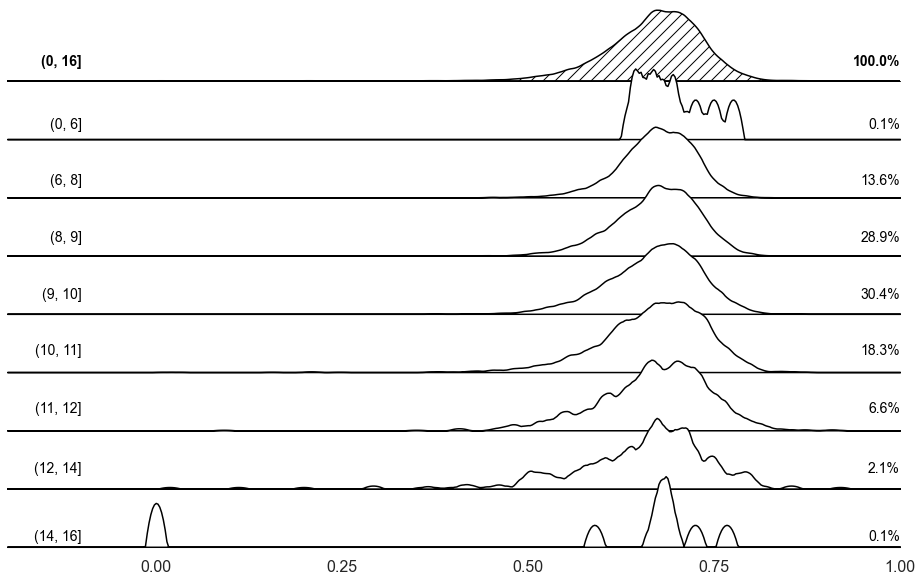

In [11]:
fig = ridge_plot(data, groups, publication_ready=True)